In [94]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy import optimize
from mandelagol import occultquad
from astropy.table import Table as tb

plt.rcParams['font.size'] = 24
plt.rcParams['figure.figsize'] = [20,10]

In [95]:
result = lk.search_lightcurve('TIC 1508410663', mission = 'Tess')
result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,SPOC,120,1508410663,0.0
1,TESS Sector 52,2022,SPOC,120,1508410663,0.0


In [130]:
lc = result[0].download()

In [131]:
lc.filename

'/Users/dorothyfu/.lightkurve-cache/mastDownload/TESS/tess2021175071901-s0040-0000001508410663-0211-s/tess2021175071901-s0040-0000001508410663-0211-s_lc.fits'

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

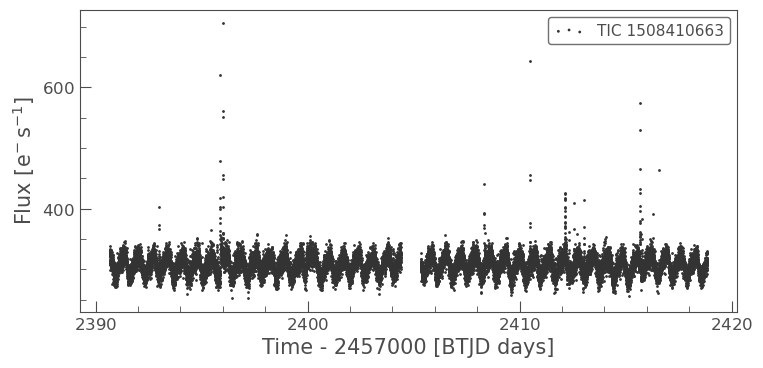

In [132]:
lc.scatter()

(2391.0, 2396.0)

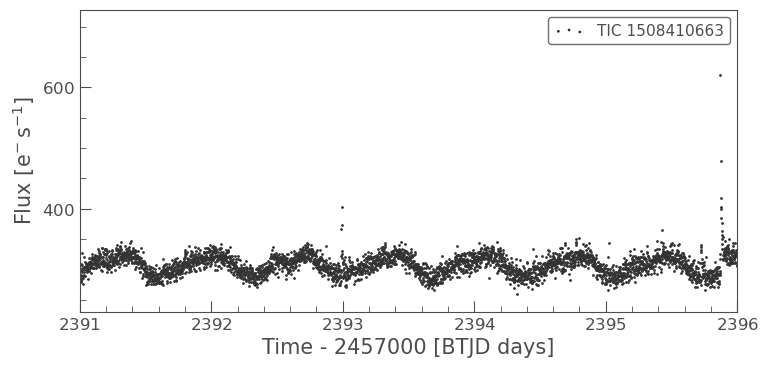

In [133]:
lc.scatter()
plt.xlim(2391,2396)

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

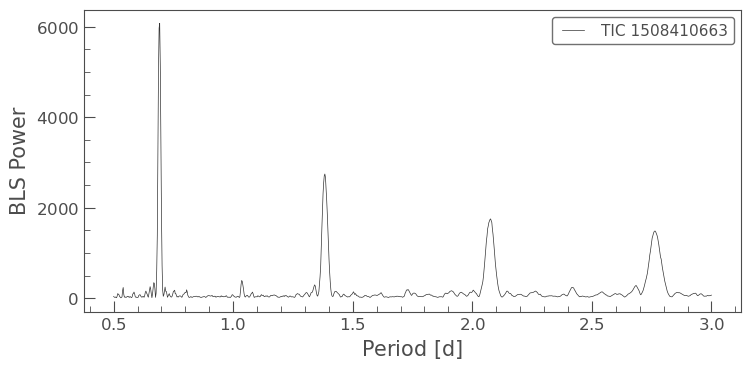

In [134]:
period = np.linspace(0.5,3.0,1000)
duration = np.linspace(0.01,0.1,10)
bls = lc.to_periodogram(method = 'bls', period = period, duration = duration)
bls.plot()

In [135]:
period = bls.period_at_max_power
t0 = bls.transit_time_at_max_power
dur = bls.duration_at_max_power
print(period,t0,dur)

0.6926926926926926 d 2390.8878052096657 0.1 d


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

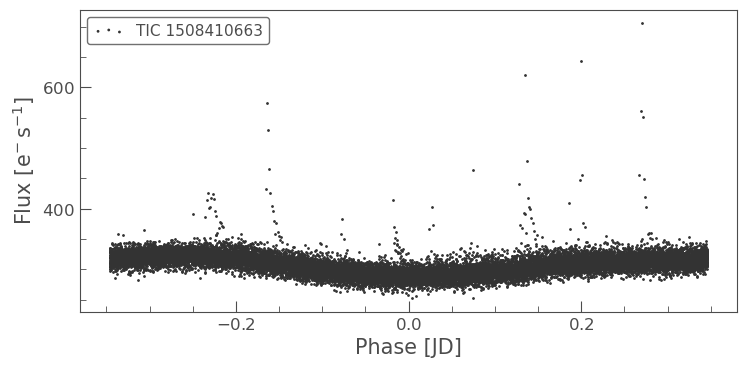

In [136]:
lc.fold(period = period, epoch_time = t0).scatter()

(2392.3, 2392.5)

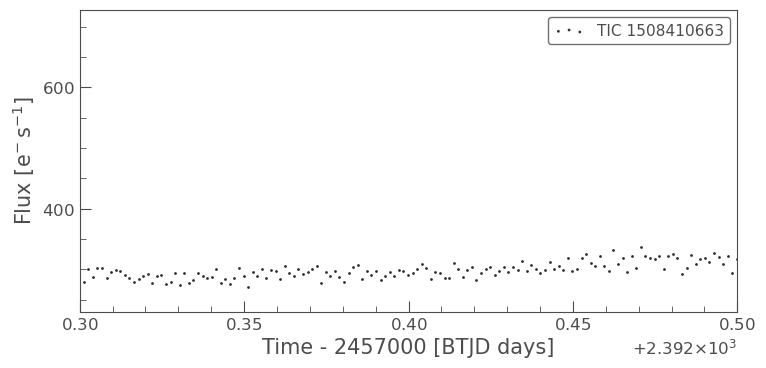

In [137]:
lc.scatter()
plt.xlim(2392.3,2392.5)

In [138]:
time = lc.time.to_value('jd')
flux = lc.flux.to_value()

# The following lines get rid of bad data points that contain 'NaN' (not a number) values
ok = np.isfinite(flux)
time = time[ok]
flux = flux[ok]

# Now, let's divide the flux by the median flux, so it is centered around 1.00
flux_norm = flux/np.median(flux)

Text(0, 0.5, 'Relative Flux')

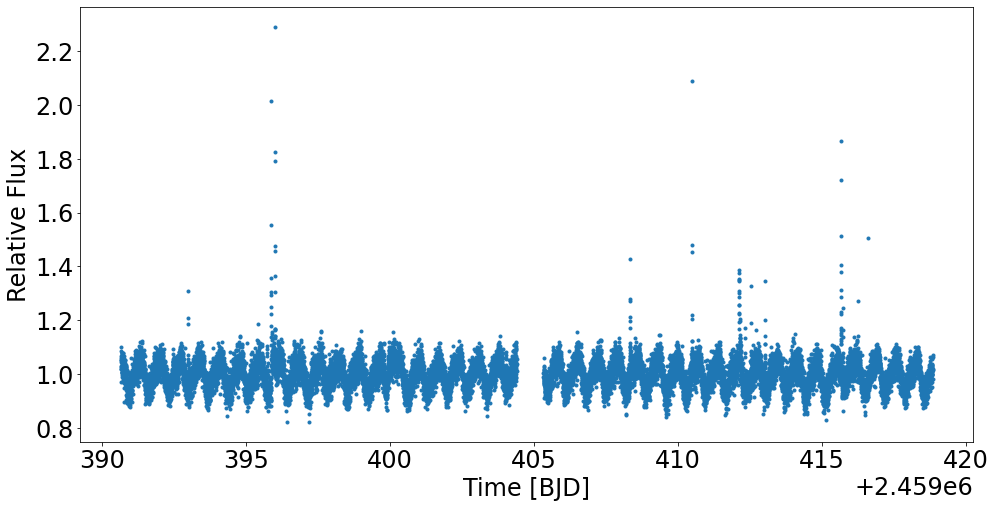

In [139]:
plt.figure(figsize=(16,8))
plt.plot(time,flux_norm,'.')
plt.xlabel('Time [BJD]')
plt.ylabel('Relative Flux')

In [140]:
def time_average(time, flux, npts):
    
    # input: time, flux, and number of sequential data points that should be averaged
    # output: time_avg and flux_avg.
    # first make sure the data are sorted in time
    
    sorted = np.argsort(time)
    time_sorted = time[sorted]
    flux_sorted = flux[sorted]
    ndata = len(time_sorted)
    
    # now perform the averaging.
    
    ndata_avg = np.int(ndata/npts) # rounds downward to nearest integer

    time_avg = np.zeros(ndata_avg)
    flux_avg = np.zeros(ndata_avg)

    for i in range(ndata_avg):
        i_start = i*npts
        i_end = i_start + npts
        time_avg[i] = np.median(time_sorted[i_start:i_end])
        flux_avg[i] = np.median(flux_sorted[i_start:i_end])

    return(time_avg, flux_avg)

def calculate_phase(time, period, t0):
    
    # returns the phase of a periodic function, defined as (time - t0) mod period.
    # the phase ranges from 0 to P, where P is the period.
    # and the input t0 is used to define where phase=0
    
    phase = (time - t0) % period  # note, % is the modulo operator
    last_half = (phase>0.5*period)
    phase[last_half] = phase[last_half] - period # recenters so that t0 occurs in the middle

    return(phase)

<ipython-input-140-0bd797e187ca>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ndata_avg = np.int(ndata/npts) # rounds downward to nearest integer


Text(0.5, 1.0, 'Time-averaged and phase-folded light curve')

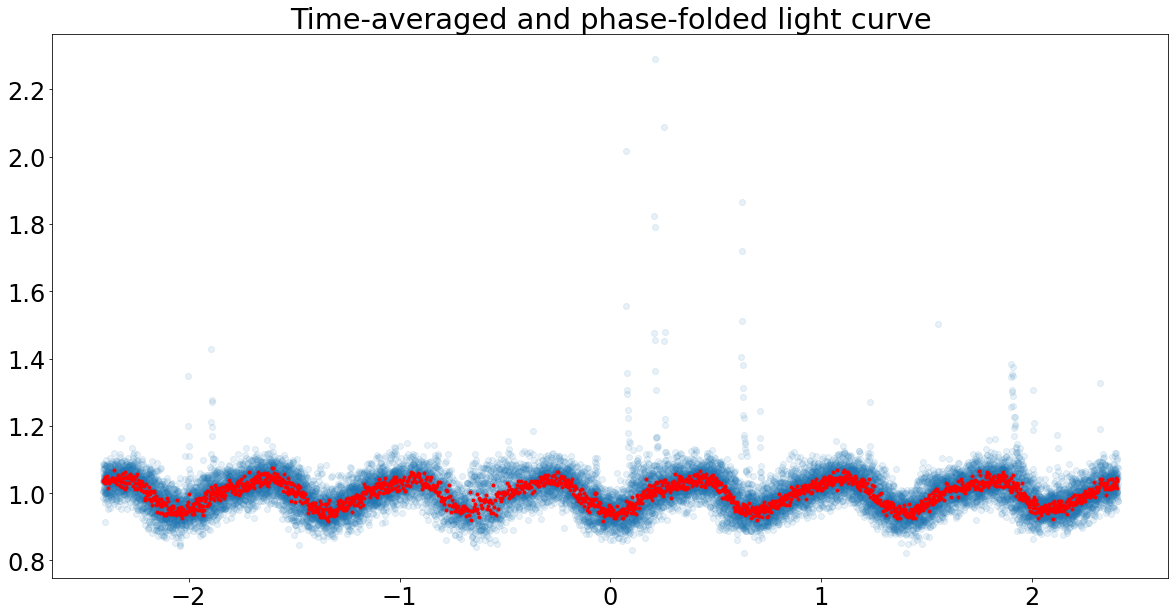

In [141]:
period = 4.8101025 # I found this period in the paper by Zhou et al. 2017, Table 6
t0 = 2455961.38467 # also from Zhou et al. 2017, Table 6
phase = calculate_phase(time, period, t0)

plt.plot(phase, flux_norm, 'o', alpha=0.1)
phase_avg, flux_avg = time_average(phase, flux_norm, 10)
plt.plot(phase_avg, flux_avg, 'r.')
plt.title('Time-averaged and phase-folded light curve')

<ipython-input-140-0bd797e187ca>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ndata_avg = np.int(ndata/npts) # rounds downward to nearest integer


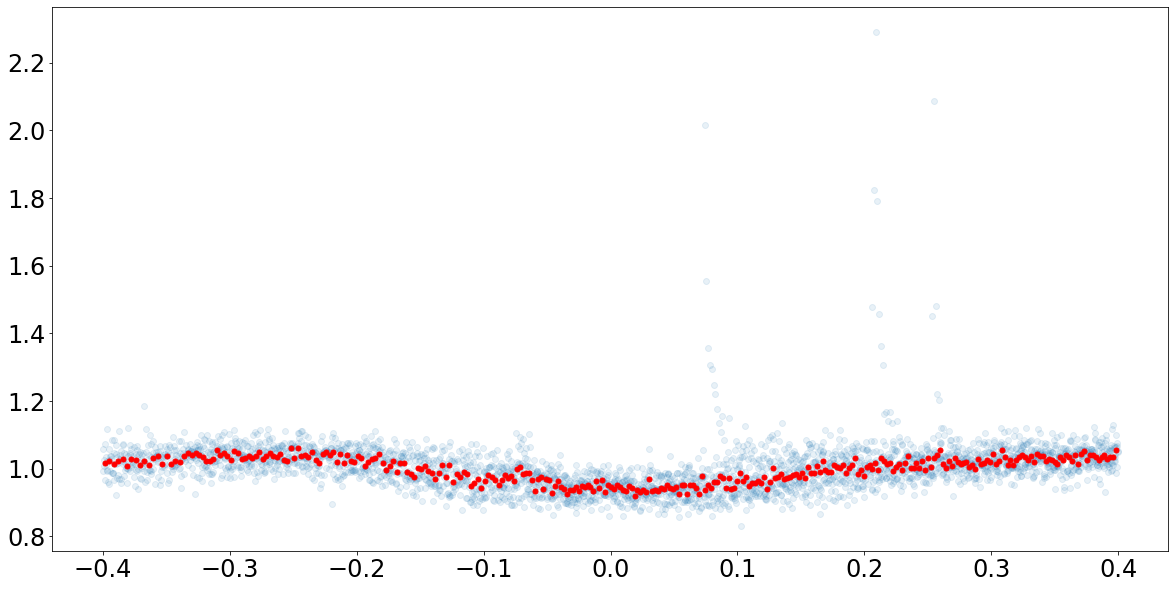

In [142]:
# Now let's select a portion to fit with a model.

region_to_fit = (np.abs(phase) <= 0.4)
t = time[region_to_fit]
f = flux_norm[region_to_fit]
ph = phase[region_to_fit]

plt.plot(ph, f, 'o', alpha=0.1)

# plot the averaged light curve with red dots to see
# how the signal-to-noise ratio has been improved (the fluctuations are reduced)
ph_avg, f_avg = time_average(ph, f, 10)
plt.plot(ph_avg, f_avg, 'r.', markersize=10)

Out of transit standard deviation =  0.0676388


<ErrorbarContainer object of 3 artists>

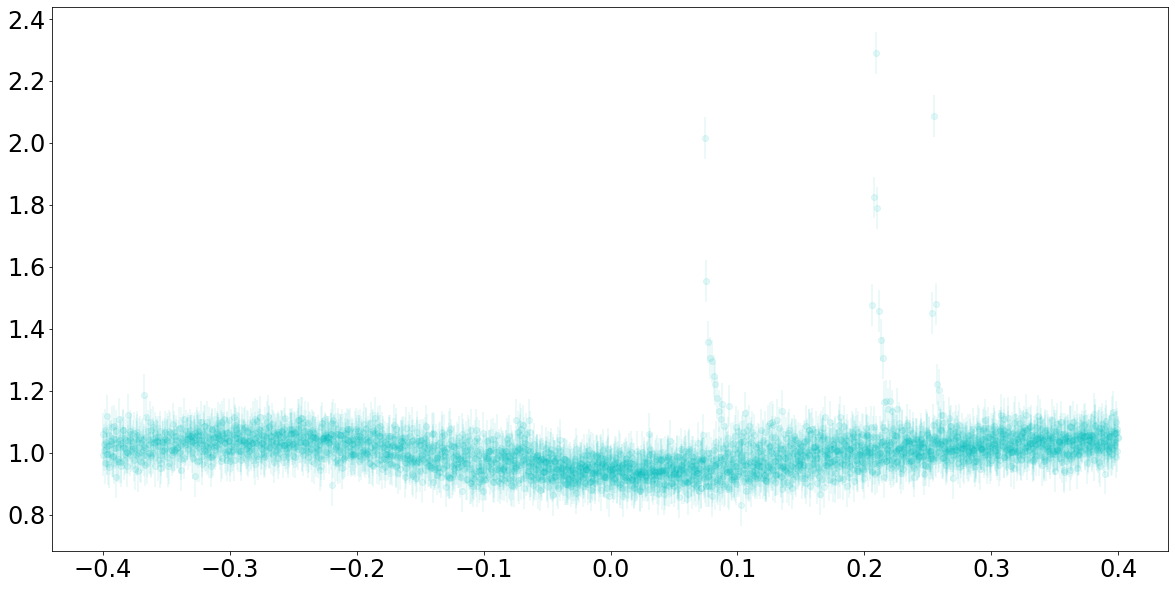

In [143]:
# Use the standard deviation outside of transits as an estimate of the uncertainty in each flux data point

oot = np.abs(ph) >= 0.2
f_oot_std = np.std(f[oot])
print("Out of transit standard deviation = ", f_oot_std)
f_unc = 0.0*t + f_oot_std
plt.errorbar(ph,f,yerr=f_unc,fmt='co',alpha=0.1)

In [90]:
# Here is the model light curve, using the 'occultquad' function from Mandel & Agol

def transit_lightcurve(params, t, period):
    t0, k, a, b, u = params
#
# period = period in days (not a free parameter; it's OK to use an estimate from previous work)
# t0 = midpoint in BJD_TDB
# k = (radius of planet) / (radius of star)
# a = (radius of orbit) / (radius of star)
# b = transit impact parameter = a*cos(incl)/Rstar
# u = limb darkening parameter (0 for uniform intensity, 0.6 for Sun-like)
#
    phi = 2.*np.pi*(t-t0)/period
    x = a*np.sin(phi)
    y = b*np.cos(phi)
    s = np.sqrt(x*x + y*y)
    flux_calc, flux_no_limb_darkening = occultquad(s,u,0.0,k)
        
    return(flux_calc)

def transit_lightcurve_residuals(params, t, period, f, f_unc):
    f_calc = transit_lightcurve(params, t, period)
    res = (f-f_calc)/f_unc
    return(res)

In [91]:
param_guess = [0.0, np.sqrt(0.006), 4.0, 0.5, 0.6]
output = optimize.least_squares(transit_lightcurve_residuals, param_guess, args=(t,period,f,f_unc))

popt = output.x
J = output.jac

cov = np.linalg.inv(J.T.dot(J))

unc = np.sqrt(np.diagonal(cov))
print(popt)
print(unc)
f_calc = transit_lightcurve(popt, t, period)


LinAlgError: Singular matrix

In [73]:
# plt.errorbar(ph,f,yerr=f_unc,fmt='co',alpha=0.1)
# plt.plot(ph,f_calc,'ro',alpha=0.1)